In [1]:
import json
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

In [3]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

from nltk.stem import LancasterStemmer
stemmer = LancasterStemmer()

[nltk_data] Downloading package stopwords to C:\Users\Arpit
[nltk_data]     Tiwari\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Arpit
[nltk_data]     Tiwari\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to C:\Users\Arpit
[nltk_data]     Tiwari\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [5]:
from lime.lime_text import LimeTextExplainer

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [7]:
from ortools.graph import pywrapgraph

In [8]:
# Data has been retrieved from the public accessible Jira instance of the open source project apache HADOOP.
# Check this URL: https://issues.apache.org/jira .
with open('hadoop_issues.json') as f:
    issues = json.load(f)
issues = issues['issues']

Length of the raw dataset

In [9]:
len(issues)

1000

In [10]:
extra_stopwords = ["a", "about", "above", "after", "again", "against", "ain", "all", "am", "an", "and", "any", "are", "aren", "aren't", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "can", "couldn", "couldn't", "d", "did", "didn", "didn't", "do", "does", "doesn", "doesn't", "doing", "don", "don't", "down", "during", "each", "few", "for", "from", "further", "had", "hadn", "hadn't", "has", "hasn", "hasn't", "have", "haven", "haven't", "having", "he", "her", "here", "hers", "herself", "him", "himself", "his", "how", "i", "if", "in", "into", "is", "isn", "isn't", "it", "it's", "its", "itself", "just", "ll", "m", "ma", "me", "mightn", "mightn't", "more", "most", "mustn", "mustn't", "my", "myself", "needn", "needn't", "no", "nor", "not", "now", "o", "of", "off", "on", "once", "only", "or", "other", "our", "ours", "ourselves", "out", "over", "own", "re", "s", "same", "shan", "shan't", "she", "she's", "should", "should've", "shouldn", "shouldn't", "so", "some", "such", "t", "than", "that", "that'll", "the", "their", "theirs", "them", "themselves", "then", "there", "these", "they", "this", "those", "through", "to", "too", "under", "until", "up", "ve", "very", "was", "wasn", "wasn't", "we", "were", "weren", "weren't", "what", "when", "where", "which", "while", "who", "whom", "why", "will", "with", "won", "won't", "wouldn", "wouldn't", "y", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves", "could", "he'd", "he'll", "he's", "here's", "how's", "i'd", "i'll", "i'm", "i've", "let's", "ought", "she'd", "she'll", "that's", "there's", "they'd", "they'll", "they're", "they've", "we'd", "we'll", "we're", "we've", "what's", "when's", "where's", "who's", "why's", "would"]

In [11]:
# Keep only the issues with assignee.
issues = [issue for issue in issues if issue['fields'].get('assignee') is not None]

In [12]:
len(issues)

677

In [13]:
# Keep only the issues of the 4 most important employees, i.e. employees with the highest number of assigned issues (statistical significance).
issues = [issue for issue in issues if issue['fields']['assignee']['key'] in ['stevel@apache.org', 'gabor.bota', 'danielzhou', 'ajisakaa']]

In [14]:
fake_names = {
    'stevel@apache.org': 'john',
    'gabor.bota': 'jane',
    'danielzhou': 'johnny',
    'ajisakaa': 'richard'
}
for issue in issues:
    issue['fields']['assignee']['key'] = fake_names[issue['fields']['assignee']['key']]

In [15]:
len(issues)

174

In [16]:
unique_assignees_to_number_mapping = {assignee: key for key, assignee in enumerate(list(set(issue['fields']['assignee']['key'] for issue in issues)))}
unique_person_names = sorted([key for key in unique_assignees_to_number_mapping], key=lambda name: unique_assignees_to_number_mapping[name])
print(unique_assignees_to_number_mapping)

{'johnny': 0, 'jane': 1, 'john': 2, 'richard': 3}


Data Processing and exploration

In [17]:
a = issues[0]

In [18]:
#a

In [19]:
a['fields']['description']

"We have the following comment and implementation in DynamoDBMetadataStore:\r\n{noformat}\r\n        // When this class has support for authoritative\r\n        // (fully-cached) directory listings, we may also be able to answer\r\n        // TRUE here.  Until then, we don't know if we have full listing or\r\n        // not, thus the UNKNOWN here:\r\n        meta.setIsEmptyDirectory(\r\n            hasChildren ? Tristate.FALSE : Tristate.UNKNOWN);\r\n{noformat}\r\n\r\nWe have authoritative listings now in dynamo since HADOOP-15621, so we should resolve this comment, implement the solution and test it. "

In [24]:
a['fields']['summary']

'Should be able to set empty directory flag to TRUE in DynamoDBMetadataStore#innerGet when using authoritative directory listings'

In [25]:
unique_assignees_to_number_mapping = {assignee: key for key, assignee in enumerate(list(set(issue['fields']['assignee']['key'] for issue in issues)))}
unique_person_names = sorted([key for key in unique_assignees_to_number_mapping], key=lambda name: unique_assignees_to_number_mapping[name])
print(unique_assignees_to_number_mapping)

{'johnny': 0, 'jane': 1, 'john': 2, 'richard': 3}


In [26]:
columns = {
    'class': [issue['fields']['assignee']['key'] for issue in issues],
    'text': [(issue['fields']['description'] if issue['fields']['description'] is not None else '') + ' ' + issue['fields']['summary'] for issue in issues],
}

In [27]:
# Compose and clean up text.
# The text of each issue is composed of two attrributes, namely description and summary (see above).
# Removal of english stop words is performed as well as lemmatization and stemming.
# Lemmatization (a Text Normalization technique) is the process of grouping together the different inflected forms of a word so they can be analysed as a single item.
# Stemming is the process of reducing inflected (or sometimes derived) words to their base or root form.
# Lemmatization, unlike Stemming, reduces the inflected words properly ensuring that the root word belongs to the language. In Lemmatization root word is called Lemma.
# Stemming is different to Lemmatization in the approach it uses to produce root forms of words and the word produced.
# Also lemmatization and stemming techniques decrease the number of features of each row as far as machine learning is concerned.
for i in range(len(columns['text'])):
    columns['text'][i] = ' '.join([stemmer.stem(wordnet_lemmatizer.lemmatize(word.lower(), pos='v')) for word in columns['text'][i].split() if word.lower() not in stopwords.words('english') + extra_stopwords])

In [28]:
issues_df = pd.DataFrame.from_dict(columns)
#issues_df

In [29]:
issues_df.describe()

,class,text
count,174,174
unique,4,174
top,john,opportun improv distcp delet perform scal obje...
freq,78,1


In [30]:
issues_df.head()

,class,text
0,jane,follow com impl dynamodbmetadatastore: {noform...
1,jane,jir cov following: * assert tabl nam config dy...
2,johnny,"currently, abf renam delet timeout check, fail..."
3,richard,testleaderelectorserv hang wait testingzookeep...
4,johnny,"temp fix, serv fix tak much long tim rol out. ..."


In [31]:
issues_df['class'].value_counts().loc[lambda x : x>5]

john       78
jane       38
johnny     34
richard    24
Name: class, dtype: int64

Text(0, 0.5, 'number of issues')

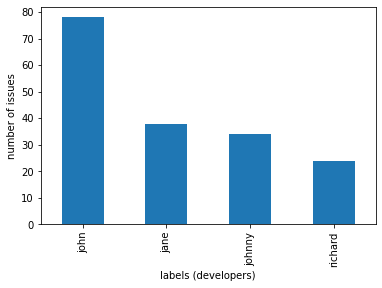

In [32]:
ax = issues_df['class'].value_counts().plot(kind='bar')
ax.set_xlabel('labels (developers)')
ax.set_ylabel('number of issues')

In [33]:
issues_df['label'] = issues_df['class'].map(unique_assignees_to_number_mapping)

In [34]:
X = issues_df['text']
y = issues_df['label']
# Tokenization, tag/feature generation and removal of frequently occured tags/words.
cv = CountVectorizer(stop_words='english', max_df=0.6)
X_transformed = cv.fit_transform(X)

In [35]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X_transformed, y, range(0, len(issues_df)), test_size=0.25, random_state=42)
print('Train size %s' % X_train.shape[0])
print('Test size %s' % X_test.shape[0])

print('Number of features %s' % X_test.shape[1])

Train size 130
Test size 44
Number of features 2403


In [36]:
issues_df.head()

,class,text,label
0,jane,follow com impl dynamodbmetadatastore: {noform...,1
1,jane,jir cov following: * assert tabl nam config dy...,1
2,johnny,"currently, abf renam delet timeout check, fail...",0
3,richard,testleaderelectorserv hang wait testingzookeep...,3
4,johnny,"temp fix, serv fix tak much long tim rol out. ...",0


In [37]:
h = cv.vocabulary_

In [38]:
len(h)

2403

In [39]:
len(h.keys())

2403

In [40]:
count_array = X_transformed.toarray()
df = pd.DataFrame(data=count_array,columns = cv.get_feature_names())
print(df)

     00  00000  0002  0005  007  01  014  015  02  021  ...  xzf  yarn  \
0     0      0     0     0    0   0    0    0   0    0  ...    0     0   
1     0      0     0     0    0   0    0    0   0    0  ...    0     0   
2     0      0     0     0    0   0    0    0   0    0  ...    0     0   
3     0      0     0     0    0   0    0    0   0    0  ...    0     0   
4     0      0     0     0    0   0    0    0   0    0  ...    0     0   
..   ..    ...   ...   ...  ...  ..  ...  ...  ..  ...  ...  ...   ...   
169   0      0     0     0    0   0    0    0   0    0  ...    0     0   
170   0      0     0     0    0   0    0    0   0    0  ...    0     0   
171   0      0     0     0    0   0    0    0   0    0  ...    0     0   
172   0      0     0     0    0   0    0    0   0    0  ...    0     0   
173   0      0     0     0    0   0    0    0   0    0  ...    0     0   

     yesdirs  zero  zhou  zich  zk  zon  zookeep  über  
0          0     0     0     0   0    0        0     0

Applying Naive Bayes For Classification

In [41]:
# Naive Bayes classifier for multinomial models.
# The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification).
# The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.
naive_clf = MultinomialNB()
naive_clf.fit(X_train,y_train)
naive_clf.score(X_test,y_test)


0.7954545454545454

In [42]:
naive_clf.score(X_train,y_train)

0.9692307692307692

In [43]:
y_test

155    2
144    2
101    2
127    1
140    2
138    2
42     0
15     0
126    2
65     2
112    1
60     0
45     3
51     2
31     1
9      1
113    2
55     1
24     3
154    2
137    2
166    3
128    2
29     3
56     3
41     3
109    2
19     3
16     0
78     2
30     2
18     2
12     0
66     2
117    2
118    1
142    2
163    2
38     0
139    2
104    0
67     2
147    2
2      0
Name: label, dtype: int64

In [44]:
#m = naive_clf.predict(X_transformed[indices_train])

In [45]:
#{'jane': 0, 'john': 1, 'johnny': 2, 'richard': 3}

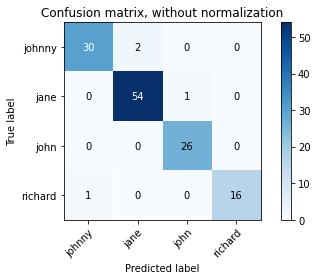

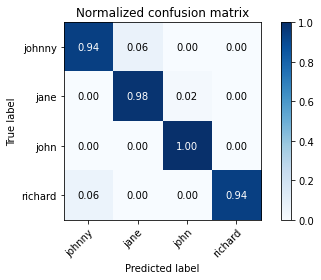

In [46]:
y_predicted = [unique_person_names[i] for i in  naive_clf.predict(X_transformed[indices_train])]
y_true = issues_df.iloc[indices_train]['class'].to_list()
class_names = unique_person_names

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_predicted, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_predicted, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Finding the result for the test Data

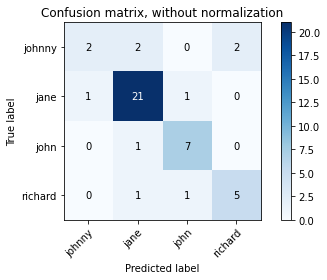

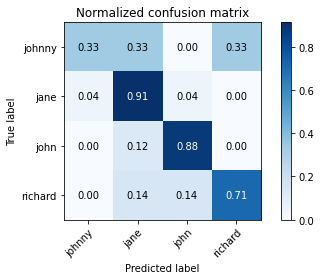

In [47]:
y_predicted_test = [unique_person_names[i] for i in  naive_clf.predict(X_transformed[indices_test])]
y_true_test = issues_df.iloc[indices_test]['class'].to_list()
class_names = unique_person_names

def plot_confusion_matrix(y_true_test, y_predicted_test, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true_test,y_predicted_test)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true_test, y_predicted_test, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_true_test, y_predicted_test, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [52]:
aa = naive_clf.predict_proba(X_test)

In [53]:
#Jan
y_test[[155]]
y_test

155    2
144    2
101    2
127    1
140    2
138    2
42     0
15     0
126    2
65     2
112    1
60     0
45     3
51     2
31     1
9      1
113    2
55     1
24     3
154    2
137    2
166    3
128    2
29     3
56     3
41     3
109    2
19     3
16     0
78     2
30     2
18     2
12     0
66     2
117    2
118    1
142    2
163    2
38     0
139    2
104    0
67     2
147    2
2      0
Name: label, dtype: int64

In [54]:
y_test[y_test == 0]

42     0
15     0
60     0
16     0
12     0
38     0
104    0
2      0
Name: label, dtype: int64

In [55]:
aa

array([[2.44e-016, 1.05e-013, 1.00e+000, 1.87e-026],
       [1.29e-012, 6.36e-008, 1.00e+000, 6.41e-015],
       [3.84e-015, 6.63e-013, 1.00e+000, 6.30e-020],
       [1.12e-002, 1.15e-001, 8.74e-001, 1.44e-005],
       [5.76e-004, 5.23e-001, 4.76e-001, 3.43e-008],
       [1.07e-007, 4.96e-011, 6.55e-001, 3.45e-001],
       [1.00e+000, 4.67e-011, 7.59e-007, 6.66e-005],
       [8.79e-001, 2.03e-005, 1.04e-001, 1.67e-002],
       [3.27e-008, 4.38e-010, 1.00e+000, 1.43e-007],
       [1.42e-004, 2.94e-005, 1.00e+000, 2.20e-010],
       [3.24e-014, 9.20e-009, 8.46e-006, 1.00e+000],
       [9.47e-001, 2.92e-012, 5.12e-002, 1.70e-003],
       [8.64e-013, 2.63e-009, 6.14e-004, 9.99e-001],
       [8.82e-004, 1.52e-009, 9.99e-001, 2.01e-004],
       [3.48e-014, 1.31e-005, 1.00e+000, 1.74e-015],
       [5.68e-005, 2.62e-006, 2.36e-004, 1.00e+000],
       [2.34e-006, 1.70e-005, 1.00e+000, 1.91e-007],
       [8.71e-026, 1.00e+000, 2.51e-019, 2.22e-027],
       [1.15e-011, 8.21e-017, 9.87e-001, 1.30e

In [56]:
# Text Explainer for explaining the selected examples.
# Reference: https://arxiv.org/abs/1602.04938
# The Explanations help us to check the reliability and validity of the trained machine learning model.
# The Explanations confirm that the model chooses the right label/class for the right reason (e.g. meaningful words/features).
explainer = LimeTextExplainer(class_names=unique_person_names)

In [57]:
def explain_classification(text, classifier):
    return explainer.explain_instance(text, lambda x: classifier.predict_proba(cv.transform(x)), top_labels=4)

In [58]:
unique_assignees_to_number_mapping

{'johnny': 0, 'jane': 1, 'john': 2, 'richard': 3}

In [59]:
def analyze_selected_examples(index):
    print(index)
    print('Real selected label: %s' % issues_df.iloc[index]['class'])
    print('Probabilities of each label: %s' % naive_clf.predict_proba(cv.transform([issues_df.iloc[index]['text']])))
    print('Summary: %s' % issues[index]['fields']['summary'])
    print('Description: %s' % issues[index]['fields']['description'] if issues[index]['fields']['description'] is not None else '')
    exp = explain_classification(issues_df.iloc[index]['text'], naive_clf)
    exp.show_in_notebook()
    exp.save_to_file('%s.html' % (index))
    return exp

Using BOW Keras

Preprocessing for Neural

In [60]:

import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils
from tensorflow.keras.utils import to_categorical 

In [61]:
num_classes = 4
max_words = 2403

In [62]:
#train_posts = df['post'][:train_size] = X
#train_tags  = y
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, range(0, len(issues_df)), test_size=0.25, random_state=42)
print('Train size %s' % X_train.shape[0])
print('Test size %s' % X_test.shape[0])

#print('Number of features %s' % X_test.shape[1])

Train size 130
Test size 44


In [63]:
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(X_train) # only fit on train

x_train = tokenize.texts_to_matrix(X_train)
x_test = tokenize.texts_to_matrix(X_test)

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)


from keras.utils import np_utils

In [64]:

num_classes = np.max(y_train) + 1
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

In [65]:
x_train.shape
x_train = x_train.reshape(-1, 2403)
y_train.shape
max_words

2403

In [66]:
batch_size = 32
epochs = 5

# Build the model
model = Sequential()
#model.add(Dense(512, input_shape=(2403,)))
model.add(Dense(512, input_dim=2403, activation="relu"))
#model.add(Activation('relu'))
#model.add(Dropout(0.05))
model.add(Dense(512, input_dim=2403, activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(512, input_dim=2403, activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(512, input_dim=2403, activation="relu"))
#model.add(Dropout(0.05))
model.add(Dense(4))
model.add(Activation('softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               1230848   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 2

In [67]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                   validation_split=0.1)

Epoch 1/5
4/4 [==============================] - 30s 347ms/step - loss: 1.3490 - accuracy: 0.3705 - val_loss: 1.2570 - val_accuracy: 0.3846
Epoch 2/5
4/4 [==============================] - 0s 26ms/step - loss: 1.1456 - accuracy: 0.5022 - val_loss: 1.1524 - val_accuracy: 0.4615
Epoch 3/5
4/4 [==============================] - 0s 26ms/step - loss: 0.8806 - accuracy: 0.6707 - val_loss: 1.0411 - val_accuracy: 0.5385
Epoch 4/5
4/4 [==============================] - 0s 28ms/step - loss: 0.5006 - accuracy: 0.8352 - val_loss: 0.8733 - val_accuracy: 0.5385
Epoch 5/5
4/4 [==============================] - 0s 27ms/step - loss: 0.1314 - accuracy: 1.0000 - val_loss: 0.6974 - val_accuracy: 0.6154


In [687]:
score1 = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score1[1])

2/2 [==============================] - 0s 4ms/step - loss: 0.7472 - accuracy: 0.7955
Test accuracy: 0.7954545617103577


In [688]:
score2 = model.evaluate(x_train, y_train,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score2[1])

5/5 [==============================] - 0s 4ms/step - loss: 0.1800 - accuracy: 0.9462
Test accuracy: 0.9461538195610046


Saving the Model

In [694]:
# Calling `save('my_model')` creates a SavedModel folder `my_model`.
model.save("my_model_neural_BOW")

# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model("my_model_neural_BOW")

INFO:tensorflow:Assets written to: my_model_neural_BOW\assets


In [698]:
score3 = reconstructed_model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score1[1])

2/2 [==============================] - 0s 4ms/step - loss: 0.7472 - accuracy: 0.7955
Test accuracy: 0.7954545617103577


In [697]:
""""
#Saving the model
import pickle
filename = 'onlyNeural_BOW_simple.sav'
pickle.dump(model, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

import pickle
saved_model = pickle.dumps(model)
 
# Load the pickled model
model_from_pickle = pickle.loads(saved_model)
"""""

'"\n#Saving the model\nimport pickle\nfilename = \'onlyNeural_BOW_simple.sav\'\npickle.dump(model, open(filename, \'wb\'))\n \n# some time later...\n \n# load the model from disk\n#loaded_model = pickle.load(open(filename, \'rb\'))\n#result = loaded_model.score(X_test, Y_test)\n#print(result)\n\nimport pickle\nsaved_model = pickle.dumps(model)\n \n# Load the pickled model\nmodel_from_pickle = pickle.loads(saved_model)\n'

In [699]:
# y_pred = model.predict(x_test)
y_pred  = np.argmax(model.predict(x_test), axis=-1)
#y_pred
y_test  = np.argmax(y_test, axis=-1)

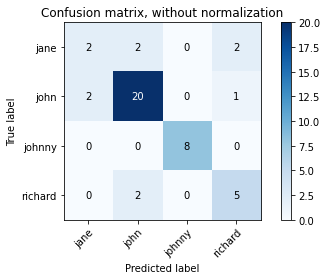

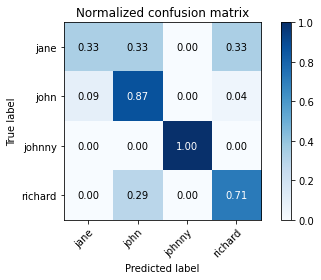

In [700]:
#y_predicted_test = [unique_person_names[i] for i in  naive_clf.predict(X_transformed[indices_test])]
#y_true_test = issues_df.iloc[indices_test]['class'].to_list()
class_names = unique_person_names

def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_test,y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

#y_test


In [701]:
# y_pred = model.predict(x_test)
y_pred_train  = np.argmax(model.predict(x_train), axis=-1)
#y_pred
y_true_train  = np.argmax(y_train, axis=-1)

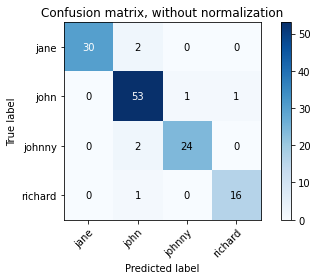

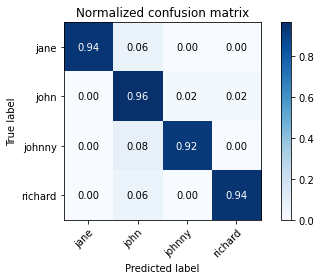

In [702]:
#y_predicted_test = [unique_person_names[i] for i in  naive_clf.predict(X_transformed[indices_test])]
#y_true_test = issues_df.iloc[indices_test]['class'].to_list()
class_names = unique_person_names

def plot_confusion_matrix(y_true_train,y_pred_train , classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true_train,y_pred_train )
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true_train, y_pred_train , classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_true_train, y_pred_train, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

#y_test


In [100]:
print(issues_df.loc[[138]])

    class                                               text  label
138  john  toc er adl troubleshoot doc hadoop-15090 {code...      1


# Using SVM

In [704]:
issues_df

,class,text,label
0,jane,follow com impl dynamodbmetadatastore: {noform...,0
1,jane,jir cov following: * assert tabl nam config dy...,0
2,johnny,"currently, abf renam delet timeout check, fail...",2
3,richard,testleaderelectorserv hang wait testingzookeep...,3
4,johnny,"temp fix, serv fix tak much long tim rol out. ...",2
...,...,...,...
169,john,"{{testconfigurationfieldsbase}} protect ""confi...",1
170,john,yet jir cre yet review hadoop-13786/hadoop-149...,1
171,richard,"findbug work without ant installed, whatev rea...",3
172,john,merg hadoop-13786 commit trunk. branch set git...,1


In [706]:
X1 = issues_df.text
y1 = issues_df.label
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.25, random_state = 42)

In [713]:

%%time
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X1_train, y1_train)

from sklearn.metrics import classification_report
y1_pred = nb.predict(X1_test)

print('accuracy %s' % accuracy_score(y1_pred, y1_test))
#print(classification_report(y1_test, y1_pred,target_names=label)

accuracy 0.5454545454545454
Wall time: 171 ms


SVM using tf-idf

In [720]:

from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X1_train, y1_train)



y1_pred = sgd.predict(X1_test)

print('accuracy %s' % accuracy_score(y1_pred, y1_test))
#print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.7954545454545454


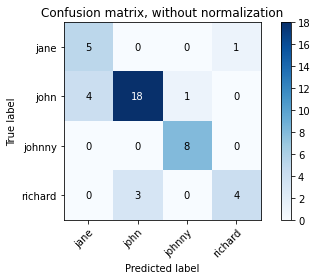

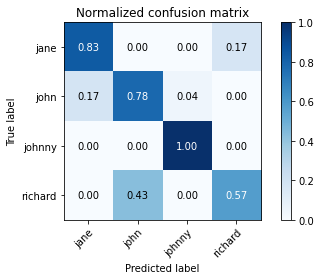

In [722]:
#y_predicted_test = [unique_person_names[i] for i in  naive_clf.predict(X_transformed[indices_test])]
#y_true_test = issues_df.iloc[indices_test]['class'].to_list()
class_names = unique_person_names

def plot_confusion_matrix(y1_test,y1_pred , classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y1_test,y1_pred )
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y1_test,y1_pred , classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y1_test, y1_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


SVM using earlier without tf-idf

In [723]:
X2 = issues_df['text']
y2 = issues_df['label']
# Tokenization, tag/feature generation and removal of frequently occured tags/words.
cv = CountVectorizer(stop_words='english', max_df=0.6)
X2_transformed = cv.fit_transform(X2)

In [724]:
X2_train, X2_test, y2_train, y2_test, indices2_train, indices2_test = train_test_split(X2_transformed, y2, range(0, len(issues_df)), test_size=0.25, random_state=42)

In [725]:
sgd2 =  SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)

In [728]:
#sgd2.fit()
sgd2.fit(X2_train, y2_train)



y2_pred = sgd2.predict(X2_test)

print('accuracy %s' % accuracy_score(y2_pred, y2_test))
#print(classification_report(y_test, y_pred,target_names=m

accuracy 0.75


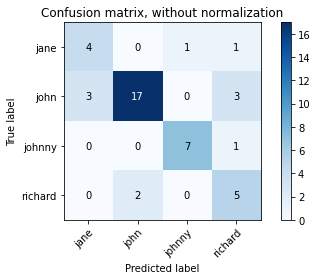

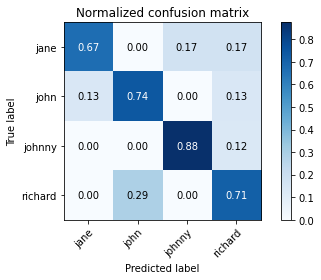

In [729]:
#y_predicted_test = [unique_person_names[i] for i in  naive_clf.predict(X_transformed[indices_test])]
#y_true_test = issues_df.iloc[indices_test]['class'].to_list()
class_names = unique_person_names

def plot_confusion_matrix(y2_test,y2_pred , classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y2_test,y2_pred )
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y2_test,y2_pred , classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y2_test, y2_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Explained Example

In [56]:
analyze_selected_examples(138)

138
Real selected label: john
Probabilities of each label: [[9.63e-01 7.62e-11 3.70e-02 4.10e-08]]
Summary: branch-2 site not building after ADL troubleshooting doc added
Description: Toc error on the ADL troubleshooting doc from HADOOP-15090
{code}
[ERROR] Failed to execute goal org.apache.maven.plugins:maven-site-plugin:3.5:site (default-cli) on project hadoop-azure-datalake: Error parsing 'hadoop-trunk/hadoop-tools/hadoop-azure-datalake/src/site/markdown/troubleshooting_adl.md': line [-1] Error parsing the model: Unable to execute macro in the document: toc -> [Help 1]
{code}


In [63]:
m = naive_clf.predict_proba(cv.transform([issues_df.iloc[138]['text']]))

In [70]:
m.shape

(1, 4)

# #Just for the PPT

Problem At hand

In [71]:
#Suppose we have a set of issues for example here we are taking suppose 4 issues
#and takingh 4 coders to solve the problem

In [170]:
list = [138, 65, 85, 109]

In [171]:
df = pd.DataFrame(columns=['Issues','John','Jane','Johhny','Ricard'])
df

,Issues,John,Jane,Johhny,Ricard


In [172]:

for i, val in enumerate(list):
  #  print (i, ",",val)
    m = naive_clf.predict_proba(cv.transform([issues_df.iloc[val]['text']]))
   # h = np.insert(m, i, val);
    df = df.append(pd.DataFrame( m,
    columns=['John','Jane','Johhny','Ricard']),
    ignore_index = True)
    df['Issues'][i] = val
    

C:\Users\Arpit Tiwari\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [173]:
df

,Issues,John,Jane,Johhny,Ricard
0,138,0.962966,7.618609e-11,3.703396e-02,4.101514e-08
1,65,0.948959,1.432573e-02,8.992374e-08,3.671567e-02
2,85,0.084173,2.020428e-04,3.791244e-07,9.156246e-01
3,109,0.530804,4.341165e-01,2.807220e-02,7.007679e-03


In [186]:
#Similarity_Score = df['Jane'][0] + df['Johhny'][2] + df['Ricard'][1] + df['John'][3]

In [187]:
Similarity_Score

0.5675196426635529